In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/S17

/content/drive/MyDrive/S17


In [2]:

import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = "/content/drive/MyDrive/S17/all_remainingfiles/pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e03340d2950>,
 ['pizza', 'steak', 'sushi'])

In [8]:
from models.transformer import Transformer

In [9]:
vit = Transformer(num_classes=len(class_names))

In [11]:
from super_repo import data_setup, engine, utils
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5080 | train_acc: 0.2773 | test_loss: 1.7408 | test_acc: 0.1979
Epoch: 2 | train_loss: 2.0565 | train_acc: 0.2812 | test_loss: 2.1049 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.2197 | train_acc: 0.2852 | test_loss: 1.6878 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2127 | train_acc: 0.3906 | test_loss: 1.0648 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1742 | train_acc: 0.3594 | test_loss: 1.0222 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.1596 | train_acc: 0.3711 | test_loss: 1.0186 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1181 | train_acc: 0.3984 | test_loss: 1.0331 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1142 | train_acc: 0.4062 | test_loss: 1.2584 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.1808 | train_acc: 0.3945 | test_loss: 1.2219 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1491 | train_acc: 0.3984 | test_loss: 1.3741 | test_acc: 0.2604


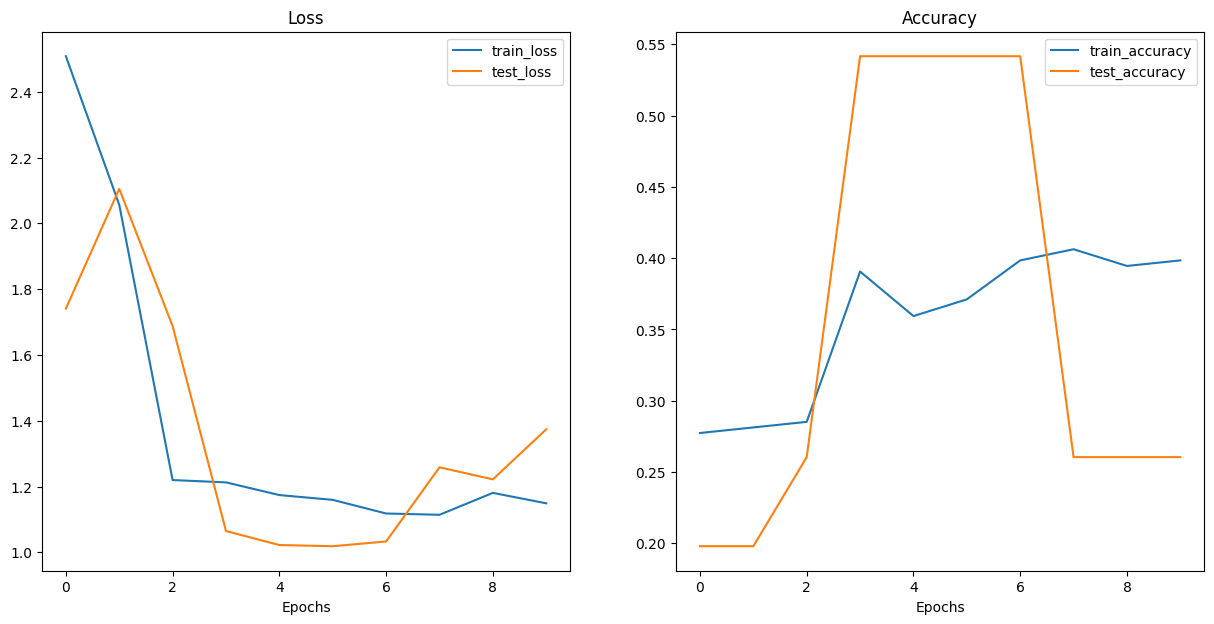

In [12]:
from super_repo.utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)